# PART 1

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import warnings, pickle, re, requests, os, community
warnings.filterwarnings('ignore')

In [2]:
REPUBLICAN = "Republican"
DEMOCRATIC = "Democratic"

## (1): Download Twitter data

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/suneman/socialgraphs2018/master/files/data_twitter/H115_tw.csv")
twitter_names = list(df.tw_name)
dict_name_party = dict(zip(df.tw_name, df.Party))

## (2): Build the network of retweets. 

In [4]:
def get_tweets(account_name):
    base_url = "https://raw.githubusercontent.com/thomasnilsson/02805-dataset/master/tweets/"
    url = base_url + account_name
    req = requests.get(url)
    return req.text

In [5]:
def get_retweet_counts():
    retweets = dict()
    rt_pattern = r'RT @(\w+)'
    for tn in twitter_names:
        ts = get_tweets(tn)
        handles = re.findall(rt_pattern, ts)
        handles = [h for h in handles if h in twitter_names]
        retweets[tn] = {h: handles.count(h) for h in handles}
    return retweets

In [6]:
file = open("retweets.obj",'rb')
retweets = pickle.load(file)
file.close()

In [7]:
# A politcian class for storing data in a neat way.
class Politician:
    def __init__(self, name, party):
        self.TwitterName = name
        self.Party = party
    
    def to_string(self):
        return "TwitterName: %s, Party: %s" % (self.TwitterName, self.Party)
    
    def __hash__(self):
        return hash(self.TwitterName)
    
    def __eq__(self, other):
        return (
                self.__class__ == other.__class__ and 
                self.TwitterName == other.TwitterName
               )

In [8]:
file = open("DG.obj",'rb')
DG = pickle.load(file)
file.close()

## (3): Visualize the network of retweets and investigate differences between the parties.

In [9]:
# Converts degree dictionary to numpy array
def degree_array(G, direction="none"):
    if direction == "in":
        return dict_to_values_array(G.in_degree())
    elif direction == "out":
        return dict_to_values_array(G.out_degree())
    else:
        return dict_to_values_array(G.degree())
    
def dict_to_values_array(D):
    return np.array(list(D.values()))

In [10]:
UG = DG.to_undirected()
politicians = UG.nodes()
degrees = 2 * np.array(degree_array(UG))
color_map = []
for p in politicians:
    if p.Party == REPUBLICAN: 
        color_map.append("red")
    elif p.Party == DEMOCRATIC: 
        color_map.append("blue")
    else: 
        color_map.append("black")

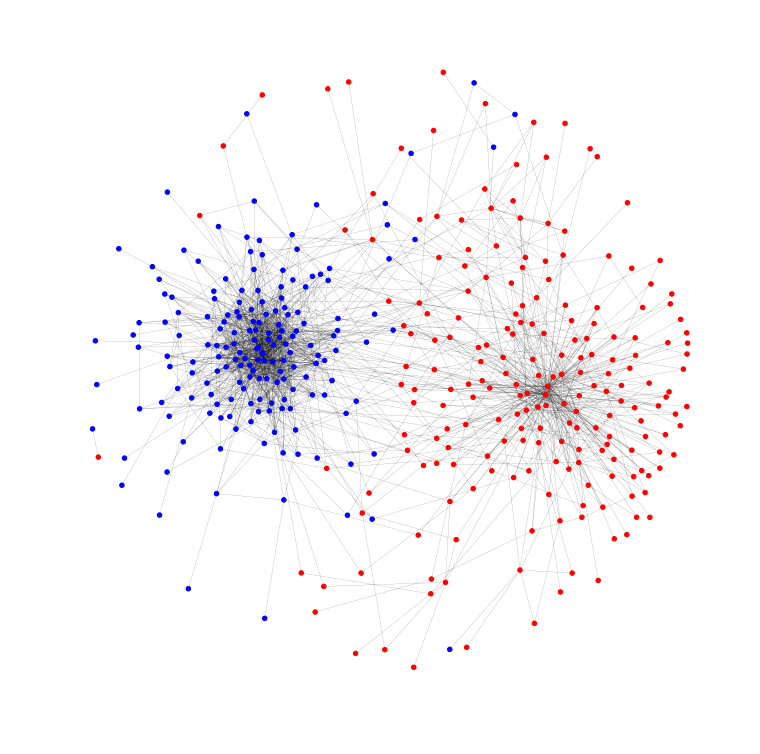

In [11]:
plt.figure(figsize=(10,10));
nx.draw(UG, node_color=color_map, node_size=20, width=0.1, line_width=1)
plt.show()

### Compare the network of Retweets with the network of Wikipedia pages (Week 5, exercise 2). 
* Do you observe any difference? How do you explain them?

In [12]:
from IPython.display import Image
Image(url='https://raw.githubusercontent.com/suneman/socialgraphs2018/master/files/blogosphere.jpg')

* Comment: It is clearly the case that just like the WikiPages, the retweets are also often kept within the party

### Now set the nodes' size proportional to their betweenness centrality. 
* What do you observe?
    * Betweenness is a measure of how often a node acts as a bridge between the shortest path between other nodes in the graph. 
    * Concretely it will represent how "diverse" a politicians retweets are, i.e. if the more people they retweet, the higher the betweenness centrality.
    * Answer: The republicans have a few very central nodes, whereas the centrality is more evenly distributed amongst the democratic nodes. 

In [13]:
B = nx.betweenness_centrality(DG)
B_values = np.array([B[pol] for pol in B])
sizes = 5000 * B_values # factor found through trial and error

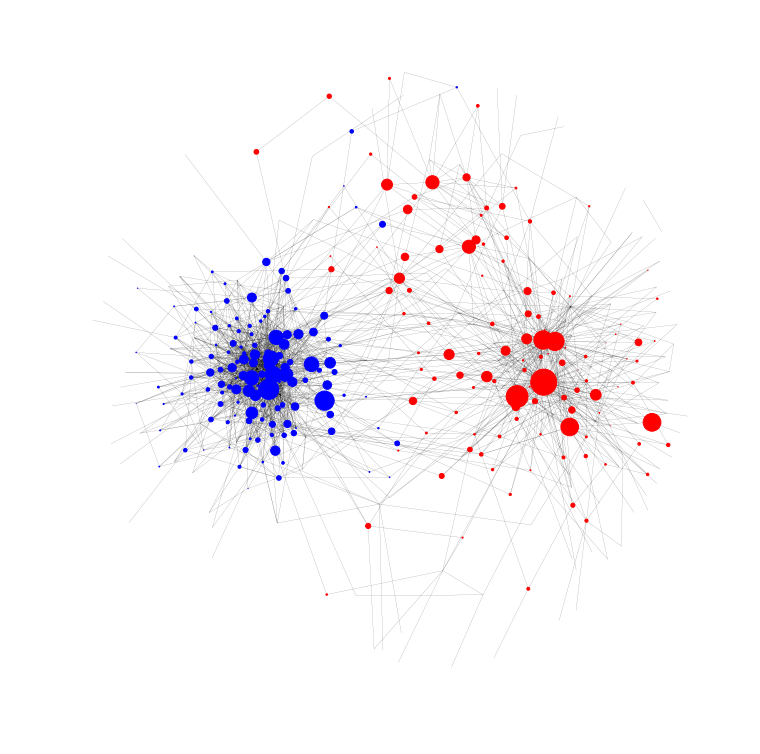

In [14]:
plt.figure(figsize=(10,10))
nx.draw(UG, node_color=color_map, node_size=sizes, width=0.1, edgecolors='#000000')
plt.show()

### Repeat the point above using eigenvector centrality instead. 
* Is there any difference? Can you explain why?
    * The eigenvector centrality represents the "page rank" which in this case can be seen as the credibility, or how "cited/retweeted" a politician is, since incoming links represent retweets, in the directed graph.
    * The reason *why* this is the case, is explained by the fact that the two centrality measures represent different concepts, which have been discussed previously.
    * The conclusion is that the repubican party seems to have a little bit of a skewed distribution when it comes to how many different politicians they retweet, and even more skewed when it comes to which other house members they each retweet.
        * There seems to be a few (5-6) republican politicians who get retweeted a lot, and the rest do not have their tweets retweeted. 
        * The democratic party is more evently distributed with regards to both centrality measures, i.e. they retweet  other house members much more evenly.
        * Questions to be asked:
            * Is a possible cause that republicans tend to be more old school, and as a consequence are not aas astive of Twitter, as the democraits?
            * It could be relevant to look at the average age of the two parties, since age likely plays into how active a person is on social media.
    

In [15]:
EV = nx.eigenvector_centrality_numpy(DG)
EV_values = np.array([EV[pol] for pol in EV])
sizes = 5000 * EV_values # factor found through trial and error

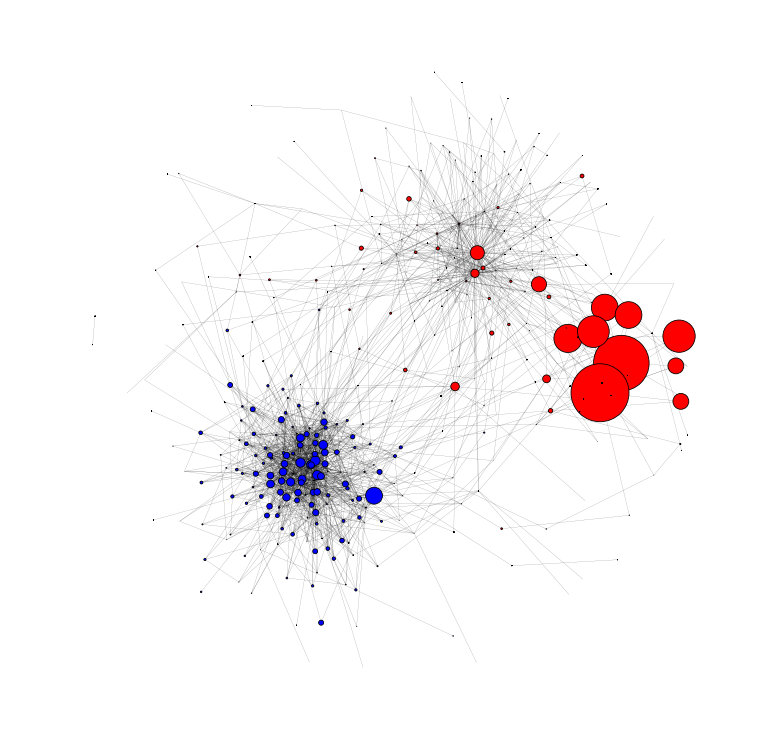

In [16]:
plt.figure(figsize=(10,10))
nx.draw(UG, node_color=color_map, node_size=sizes, width=0.1, linewidths=0.8)
plt.gca().collections[0].set_edgecolor("#000000") 
plt.show()

### Who are the three nodes with highest degree within each party? 
* And eigenvector centrality? 
* And betweenness centrality?

In [17]:
# Extract Nodes
nodes = DG.nodes()

# Split nodes on party
repub_nodes = [node for node in nodes if node.Party == REPUBLICAN]
demo_nodes = [node for node in nodes if node.Party == DEMOCRATIC]


#### Degree centrality

In [18]:
D = nx.degree(DG)
repub_deg = {pol: D[pol] for pol in repub_nodes}
demo_deg = {pol: D[pol] for pol in demo_nodes}
repub_sortby_deg = sorted(repub_deg, key=repub_deg.get)
demo_sortby_deg = sorted(demo_deg, key=demo_deg.get)

print("Degree Centrality: Top 3 Republican Twitter Accounts")
for i in range(3):
    print("\t- " + repub_sortby_deg[i].TwitterName)
    
print("Degree Centrality: Top 3 Republican Twitter Accounts")
for i in range(3):
    print("\t- " + repub_sortby_deg[i].TwitterName)

Degree Centrality: Top 3 Republican Twitter Accounts
	- RepChrisSmith
	- michaelcburgess
	- USRepRodney
Degree Centrality: Top 3 Republican Twitter Accounts
	- RepChrisSmith
	- michaelcburgess
	- USRepRodney


* Comment: Louise Slaughter died this year in March, which may explain why so many politicians retweeted her. The reason she must have been retweeted is that is hard to retweet other people when you are dead...

#### Eigenvector centrality

In [19]:
repub_ev = {pol: EV[pol] for pol in repub_nodes}
demo_ev = {pol: EV[pol] for pol in demo_nodes}
repub_sortby_ev = sorted(repub_ev, key=repub_ev.get)
demo_sortby_ev = sorted(demo_ev, key=demo_ev.get)

print("Degree EV Centrality: Top 3 Republican Twitter Accounts")
for i in range(3):
    print("\t- " + repub_sortby_ev[i].TwitterName)
    
print("Degree EV Centrality: Top 3 Republican Twitter Accounts")
for i in range(3):
    print("\t- " + demo_sortby_ev[i].TwitterName)

Degree EV Centrality: Top 3 Republican Twitter Accounts
	- RepSmucker
	- RepBrianBabin
	- LamarSmithTX21
Degree EV Centrality: Top 3 Republican Twitter Accounts
	- RepTomSuozzi
	- PeterWelch
	- RepJoeCourtney


#### Betweenness Centrality

In [20]:
repub_b = {pol: B[pol] for pol in repub_nodes}
demo_b = {pol: B[pol] for pol in demo_nodes}
repub_sortby_b = sorted(repub_b, key=repub_b.get)
demo_sortby_b = sorted(demo_b, key=demo_b.get)

print("Degree Betweenness Centrality: Top 3 Republican Twitter Accounts")
for i in range(3):
    print("\t- " + repub_sortby_b[i].TwitterName)
    
print("Degree Betweenness Centrality: Top 3 Republican Twitter Accounts")
for i in range(3):
    print("\t- " + demo_sortby_b[i].TwitterName)

Degree Betweenness Centrality: Top 3 Republican Twitter Accounts
	- repdonyoung
	- RepHalRogers
	- RepChrisSmith
Degree Betweenness Centrality: Top 3 Republican Twitter Accounts
	- RepJohnConyers
	- RepThompson
	- RepCuellar


### Plot on the same figure the distribution of outgoing strength for the republican and democratic nodes 
... (e.g. the sum of the weight on outgoing links). 
* Which party is more active in retweeting other members of the house?

In [21]:
def sum_retweets(retweets, name):
    rt = retweets[name]
    non_self_rt = {author: rt[author] for author in rt if author != name}
    return sum(non_self_rt.values())

In [22]:
repub_names = list(df[df.Party == "Republican"].tw_name)
demo_names = list(df[df.Party == "Democratic"].tw_name)
outgoing_repub = [sum_retweets(retweets, name) for name in repub_names]
outgoing_demo = [sum_retweets(retweets, name) for name in demo_names]

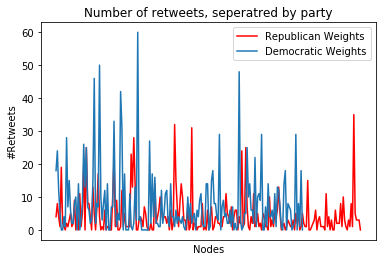

In [23]:
plt.plot(outgoing_repub, "red")
plt.plot(outgoing_demo)
plt.legend(["Republican Weights", "Democratic Weights"])
plt.title("Number of retweets, seperatred by party")
plt.xlabel("Nodes"); plt.ylabel("#Retweets"); plt.xticks([], []);
plt.show()

* Which party is more active in retweeting other members of the house?

In [24]:
avg_repub = sum(outgoing_repub) / len(outgoing_repub)
print("Avg. retweets per member (Republican): %.2f" % avg_repub)

Avg. retweets per member (Republican): 4.37


In [25]:
avg_demo = sum(outgoing_demo) / len(outgoing_demo)
print("Avg. retweets per member (Democratic): %.2f" % avg_demo)

Avg. retweets per member (Democratic): 7.80


* Conclusion: The democrats are on average twice as active when it comes to retweeting other members of the house of representatives.

### Find the 3 members of the republican party that have retweeted more often tweets from democratic members. 
* Repeat the measure for the democratic members. 
* Can you explain your results by looking at the Wikipedia pages of these members of the house?

In [26]:
def sum_cross_retweets(retweets, mapping, name):
    party = mapping[name]
    rt = retweets[name]
    cross_rt = {
        author: rt[author] for author in rt 
        if author != name and mapping[author] != party # Check if name and party is different
    }
    return sum(cross_rt.values())

In [27]:
cross_repub = {name: sum_cross_retweets(retweets, dict_name_party, name) for name in repub_names}
cross_demo = {name: sum_cross_retweets(retweets, dict_name_party, name) for name in demo_names}

In [28]:
cross_repub["RepMikeTurner"]

5

In [29]:
cross_repub_sorted = sorted(cross_repub, key=cross_repub.get, reverse=True)
print("Cross-retweeting (Republican party), top 3")
for i in range(3):
    print("\t-" + cross_repub_sorted[i])
print()
print("Cross-retweeting (Democratic party), top 3")
cross_demo_sorted = sorted(cross_demo, key=cross_demo.get, reverse=True)
for i in range(3):
    print("\t-" + cross_demo_sorted[i])

Cross-retweeting (Republican party), top 3
	-RepMikeTurner
	-CongressmanGT
	-RepRyanCostello

Cross-retweeting (Democratic party), top 3
	-RepAnnaEshoo
	-RepDebDingell
	-RepRoybalAllard


#### Republicans
* https://en.wikipedia.org/wiki/Chris_Smith_(New_Jersey_politician) - Was a democrat until 1978
* https://en.wikipedia.org/wiki/Lamar_Smith - No apparent explanation
* https://en.wikipedia.org/wiki/Jimmy_Duncan_(politician) - No apparent explanation

#### Democratic
* https://en.wikipedia.org/wiki/John_Conyers - No apparent explanation
* https://en.wikipedia.org/wiki/Steny_Hoyer - No apparent explanation
* https://en.wikipedia.org/wiki/Marcy_Kaptur - No apparent explanation

## Exercise 3: Community Detection
### Use your favorite method of community detection to find communities in the full house of representatives network. 
* Report the value of modularity found by the algorithm. 
* Is it higher or lower than what you found for the Wikipedia network? 
* Comment on your result.


#### Method used = Louvain Algorithm

In [30]:
full_part = community.best_partition(UG)
full_mod = community.modularity(full_part, UG)
full_mod

0.4715615697834234

* Both modularities are above zero, meaning it is possible for the retweets to represent two communities.

* The result gathered for the WikiPedia network was 0.45, so it's around the same.

* This means that retweets can be used as a foundation for communties in the graph, just like links to other wikipages can.

### Visualize the network, using the Force Atlas algorithm (see Lecture 5, exercise 2). 
* This time assign each node a different color based on their community. 
* Describe the structure you observe.

In [31]:
colors = ["blue", "cyan", "yellow", "green", "red", "steelblue", "purple", "gray", "magenta"]
communities = list(full_part.values())
color_list = [colors[com] for com in communities]

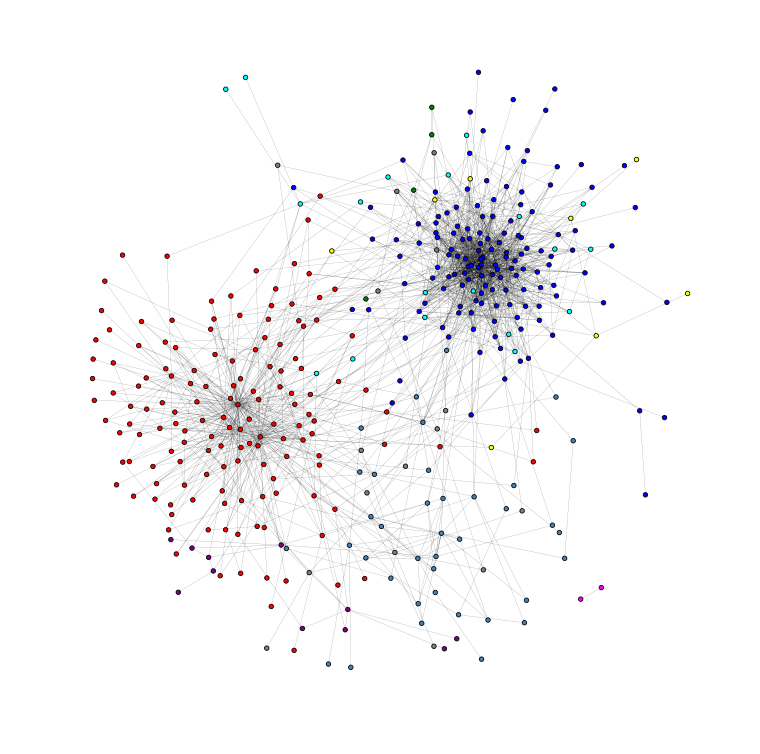

In [127]:
plt.figure(figsize=(10,10));
nx.draw(UG, node_color=color_list, node_size=20, width=0.1, linewidths=0.8)
plt.gca().collections[0].set_edgecolor("#000000")
plt.show()

**Comment**: There does seem two be two dominant communities, which are likely the two parties. There are many smaller communities with very few nodes.

* Compare the communities found by your algorithm with the parties by creating a matrix $\mathbf{D}$ with dimension $(B \times C$, where $B$ is the number of parties and $C$ is the number of communities. We set entry $D(i,j)$ to be the number of nodes that party $i$ has in common with community $j$. The matrix $\mathbf{D}$ is what we call a confusion matrix.

In [33]:
B = 2
C = len(set(communities))
D = np.zeros((B,C))
parties = [0 if n.Party == REPUBLICAN else 1 for n in nodes]

for p,c in zip(parties, communities):
    D[p,c] += 1

### Plot the confusion matrix and explain how well the communities you've detected correspond to the parties. 
Consider the following questions:
* Are there any republicans grouped with democrats (and vice versa)?
* Does the community detection algorithm sub-divide the parties? 
    * Do you know anything about American politics that could explain such sub-divisions? Answer in your own words.

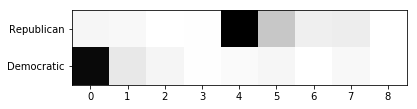

In [135]:
import matplotlib.cm as cm
plt.imshow(D, cmap=cm.binary)
plt.yticks(np.arange(2), ["Republican", "Democratic"])
plt.show()

## Part 2: What do republican and democratic members tweet about?

### Exercise 4: TF-IDF of the republican and democratic tweets.
* Create two large documents, one for the democratic and one for the republican party. Tokenize the pages, and combine the tokens into one long list including all the pages of the members of the same party.
    * Exclude all twitter handles.
    * Exclude punctuation.
    * Exclude stop words (if you don't know what stop words are, go back and read NLPP1e again).
    * Exclude numbers (since they're difficult to interpret in the word cloud).
    * Set everything to lower case.
    * Compute the TF-IDF for each document.

In [37]:
import nltk
from nltk.corpus import stopwords

In [38]:
tweets_repub = [get_tweets(name) for name in dict_name_party if dict_name_party[name] == REPUBLICAN]
tweets_demo = [get_tweets(name) for name in dict_name_party if dict_name_party[name] == DEMOCRATIC]

In [39]:
url_h115 = 'https://raw.githubusercontent.com/suneman/socialgraphs2018/master/files/data_US_congress/H115.csv'
df = pd.read_csv(url_h115)
page_names = df.WikiPageName
name_tokens = " ".join(page_names)
name_tokens = nltk.word_tokenize(name_tokens)
name_tokens = " ".join(name_tokens).replace("_", " ").replace("politician", "").lower()
name_tokens = re.findall(r'\w+', name_tokens)

In [442]:
def tweet_tokens(tweets, bad_tokens):
    bad_tokens = bad_tokens + stopwords.words('english')
    text = " ".join(tweets).lower()
    text = re.sub(r'(Rep. .*?\s)|(\sRT\s)|(\sRM\s)|(@.*?\s)|(#.*?\s)|(https.*?($|\s))' , ' ', text)
    tokens = re.findall(r'\b[a-z]+\b', text)
    return [t for t in tokens if t not in bad_tokens]

In [443]:
repub_tokens = tweet_tokens(tweets_repub, name_tokens)

In [444]:
demo_tokens = tweet_tokens(tweets_demo, name_tokens)

Calculate TFIDF function:

In [445]:
def tf_idf(doc1, doc2, N=2):
    # TF
    fd = nltk.FreqDist(doc1)
    sorted_tokens = [x[0] for x in fd.most_common()]
    tf = np.array([x[1] for x in fd.most_common()])

    # IDF
    set1, set2 = set(doc1), set(doc2)
    df = np.array([(t in set1) + (t in set2) for t in sorted_tokens])
    idf = np.log(N / df)
    
    # TFIDF
    return tf * idf, sorted_tokens

from wordcloud import WordCloud
def make_wordcloud(tokens, tfidf, title):
    # Round scores
    tfidf_rounded = np.array(tfidf, dtype="int32")
    document = " ".join([(w + " ") * n for w,n in zip(tokens, tfidf_rounded)])
    
    # Plot
    wc = WordCloud(
        background_color="white", 
        max_words=4000, contour_width=3, 
        contour_color='steelblue', 
        collocations=False
    ).generate(document)

    plt.figure(figsize=[10,5])
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

In [446]:
repub_tfidf, repub_tokens_sort = tf_idf(repub_tokens, demo_tokens, N=2)
demo_tfidf, demo_tokens_sort = tf_idf(demo_tokens, repub_tokens, N=2)

* Now, create word-cloud for each party. Are these topics less "boring" than the wikipedia topics from a few weeks ago? Why? Comment on the results.

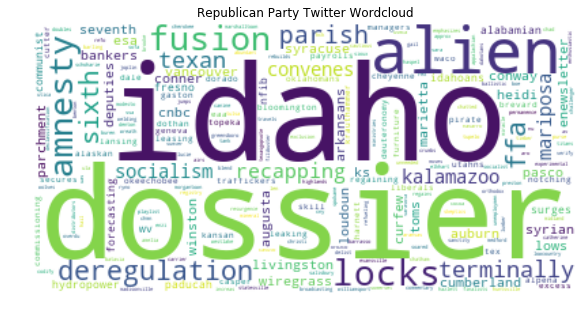

In [447]:
make_wordcloud(repub_tokens_sort, repub_tfidf, "Republican Party Twitter Wordcloud")

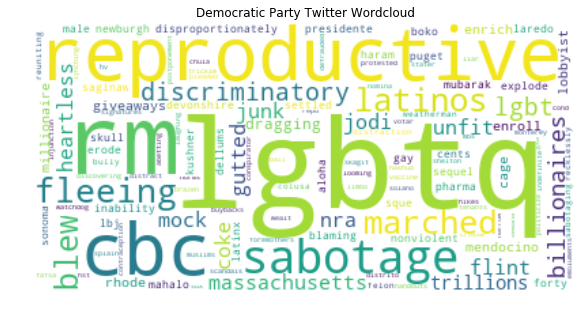

In [448]:
make_wordcloud(demo_tokens_sort, demo_tfidf, "Democratic Party Twitter Wordcloud")

## Part 3: Sentiment analysis

### Exercise 5: Sentiment over the Twitter data.

* Download the LabMT wordlist. It's available as supplementary material from Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter (Data Set S1). Describe briefly how the list was generated.

In [449]:
import csv
dataset_url = "https://journals.plos.org/plosone/article/file?type=supplementary&id=info:doi/10.1371/journal.pone.0026752.s001"
dataset_text = requests.get(dataset_url).text

In [171]:
import csv, io 
sentiment = requests.get('https://journals.plos.org/plosone/article/file?type=supplementary&id=info:doi/10.1371/journal.pone.0026752.s001').text
reader = csv.reader(io.StringIO(sentiment), delimiter='\t')
lines = [l for l in reader]
header = lines[3] # Headers are on line 4
data = lines[4:] # Discard first 4 lines

# Build Dataframe
df_sent = pd.DataFrame(data)
df_sent.columns = header

* Based on the LabMT word list, write a function that calculates sentiment given a list of tokens (the tokens should be lower case, etc).

In [191]:
# Dictionary for looking up the average score of a token
sentiment_dict = dict(zip(df_sent.word, np.array(df_sent.happiness_average, dtype="double")))

def calculate_sentiment(tokens, sentiment_dict):
    return sum([sentiment_dict[t] for t in tokens if t in sentiment_dict.keys()])

* Create two lists: one including the tweets written by democratic members, and the other including the tweets written by republican members (in the text files, tweets are separated by newlines).

In [463]:
def find_words(doc):
    doc_lower = doc.lower()
    no_tag = re.sub(r'(Rep. .*?\s)|(\sRT\s)|(\sRM\s)|(@.*?\s)|(#.*?\s)|(https.*?($|\s))' , ' ', doc_lower)
    words = re.findall(r'\b[a-z]+\b', no_tag)
    return words

In [464]:
repub_tweet_tokens = [
    find_words(tweet) 
    for collection in tweets_repub
    for tweet in collection.split("\n") 
]

demo_tweet_tokens = [
    find_words(tweet) 
    for collection in tweets_demo
    for tweet in collection.split("\n") 
]

* Calculate the sentiment of each tweet and plot the distribution of sentiment for each of the two lists. Are there significant differences between the two? Which party post more positive tweets?

In [465]:
repub_sentiments = np.array([calculate_sentiment(ts, sentiment_dict) for ts in repub_tweet_tokens])
demo_sentiments = np.array([calculate_sentiment(ts, sentiment_dict) for ts in demo_tweet_tokens])

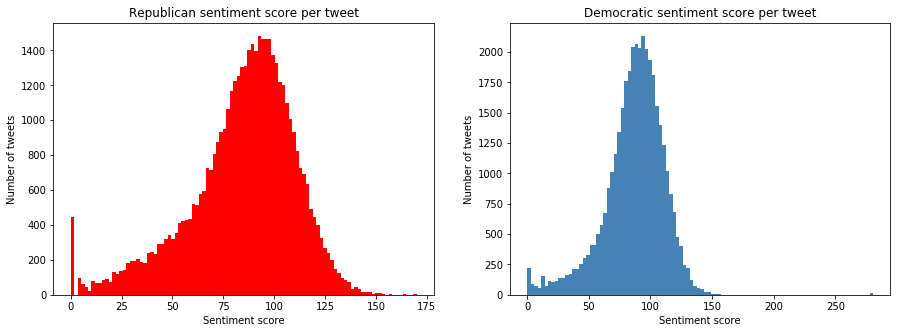

In [477]:
plt.figure(figsize=[15,5])
plt.subplot(1,2,1)
plt.hist(repub_sentimens, color="red", bins=100)
plt.title("Republican sentiment score per tweet")
plt.xlabel("Sentiment score")
plt.ylabel("Number of tweets")

plt.subplot(1,2,2)
plt.hist(demo_sentimens, color="steelblue", bins=100)
plt.title("Democratic sentiment score per tweet")
plt.xlabel("Sentiment score")
plt.ylabel("Number of tweets")
plt.show()

**Answer** 
* The Democrat representenatives tweet words with higher sentiment scores in general, as the peak is very much around a score of 100 per tweet, whereas the republican tweets are a little more spread out.
* This way of measuring does not take into account that longer tweets will almost by default have a higher sentiment score, since no words can detract from the sentiment score.

* Compute the average m and standard deviation $\sigma$ of the tweets sentiment (considering tweets by both republican and democrats).

In [467]:
sentiments_both = np.concatenate((repub_sentiments, demo_sentiments))
mean = sentiments_both.mean()
std = sentiments_both.std()

* Now consider only tweets with sentiment lower than m-2$\sigma$. We will refer to them as negative tweets. Build a list containing the negative tweets written by democrats, and one for republicans. Compute the TF-IDF for these two lists (use the same pre-processing steps in Exercise 5). Create a word-cloud for each of them. Comment on the differences between the negative contents posted by republicans and democrats.

In [468]:
repub_negative_tweets = [
    tweet for collection in repub_tweet_tokens
    for tweet in collection
    if calculate_sentiment(tweet, sentiment_dict) < (mean - 2*std)
]

demo_negative_tweets = [
    tweet for collection in demo_tweet_tokens
    for tweet in collection
    if calculate_sentiment(tweet, sentiment_dict) < (mean - 2*std)
]

In [469]:
repub_tfidf_neg, repub_neg_tokens_sort = tf_idf(repub_negative_tweets, demo_negative_tweets, N=2)
demo_tfidf_neg, demo_neg_tokens_sort  = tf_idf(demo_negative_tweets, repub_negative_tweets, N=2)

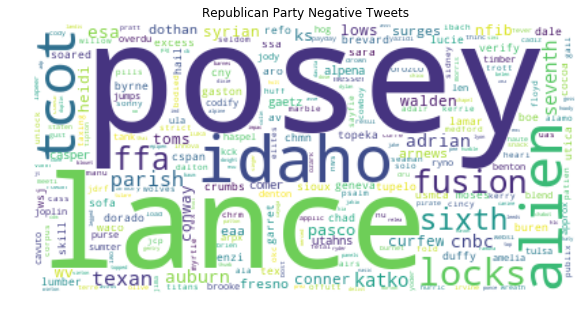

In [470]:
make_wordcloud(repub_neg_tokens_sort, repub_tfidf_neg, "Republican Party Negative Tweets")

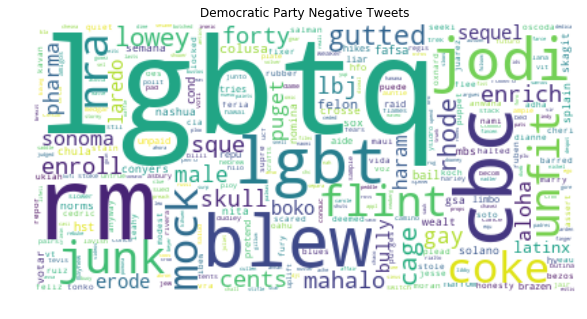

In [471]:
make_wordcloud(demo_neg_tokens_sort, demo_tfidf_neg, "Democratic Party Negative Tweets")

* Repeat the point above, but considering positive tweets instead (e.g. with sentiment larger than m+2$\sigma$). Comment on your results.

In [472]:
repub_pos_tweets = [
    tweet for collection in repub_tweet_tokens
    for tweet in collection
    if calculate_sentiment(tweet, sentiment_dict) > (mean + 2*std)
]

demo_pos_tweets = [
    tweet for collection in demo_tweet_tokens
    for tweet in collection
    if calculate_sentiment(tweet, sentiment_dict) > (mean + 2*std)
]

In [473]:
repub_tfidf_pos, repub_pos_tokens_sort = tf_idf(repub_pos_tweets, demo_pos_tweets, N=2)
demo_tfidf_pos, demo_pos_tokens_sort  = tf_idf(demo_pos_tweets, repub_pos_tweets, N=2)


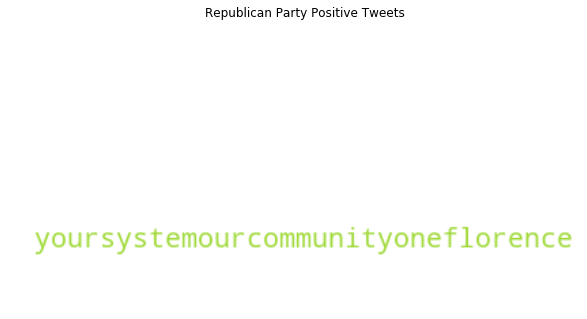

In [474]:
make_wordcloud(repub_pos_tokens_sort, repub_tfidf_pos, "Republican Party Positive Tweets")

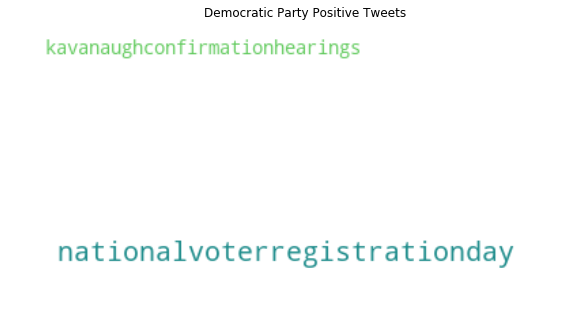

In [475]:
make_wordcloud(demo_pos_tokens_sort, demo_tfidf_pos, "Democratic Party Positive Tweets")